In [48]:
import numpy as np
from mayavi import mlab
import trimesh


from bfieldtools.coil_optimize import optimize_streamfunctions
from bfieldtools.mesh_conductor import MeshConductor

from scipy.interpolate import griddata
from bfieldtools import sphtools
import matplotlib.pyplot as plt

In [3]:
mlab.init_notebook('png')

Notebook initialized with png backend.


In [5]:
error_radius = 40

Rz = trimesh.transformations.rotation_matrix(np.pi/2., [0, 0, 1])
Ry = trimesh.transformations.rotation_matrix(np.pi/2., [1, 0, 0])
coil_mesh = trimesh.load("meshes/cylinder_50mm.stl")
# coil_mesh.apply_transform(Rz)
# coil_mesh.apply_transform(Ry)
coil = MeshConductor(
    mesh_obj=coil_mesh, 
    fix_normals=True,
    basis_name='suh', 
    N_suh=100, #100
    sph_radius=error_radius,#20
    sph_normalization="energy",
    )


Calculating surface harmonics expansion...
Computing the laplacian matrix...
Computing the mass matrix...


In [7]:
n = 10
y = np.reshape(np.linspace(-error_radius, error_radius, n), (1, n))
x = np.zeros((1, n))
z = np.zeros((1, n))

trgt_pts = np.concatenate((x.T, y.T, z.T), axis = 1)


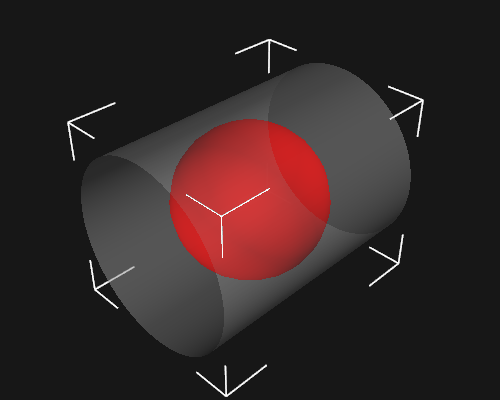

In [8]:
f = mlab.figure(bgcolor=(23./255, 23./255, 23./255), fgcolor=(.5, .5, .5), size=(500, 400))
mlab.points3d([0], [0], [0], scale_factor=error_radius*2, scale_mode='none', resolution=20, color=(1, 0, 0), opacity=0.8)


coil.plot_mesh(opacity=0.5, figure=f, )
ol = mlab.outline(color=(1, 1, 1), line_width=1.5)

ol.outline_mode='cornered'
f



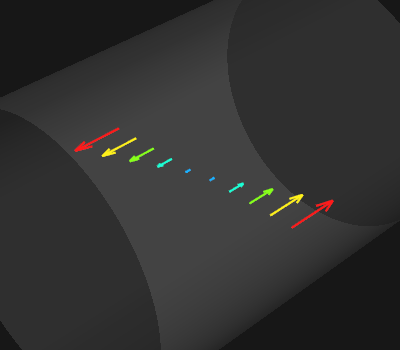

In [9]:

# trgt_pts
alm = np.zeros((coil.opts["N_sph"]* (coil.opts["N_sph"]+2),))
blm = np.zeros((coil.opts["N_sph"]* (coil.opts["N_sph"]+2),))


blm[7] += 1


sphfield = sphtools.field(trgt_pts, alm, blm, coil.opts["N_sph"])
target_field = sphfield / np.max(sphfield[:, 0])

field_y = target_field.copy()

field_y[:, 2] = 0
field_y[:, 1] = 0

field_y
mlab.clf()
f = mlab.figure(bgcolor=(23./255, 23./255, 23./255), fgcolor=(1, 1, 1))
mlab.quiver3d(*trgt_pts.T, *field_y.T, figure=f, line_width=2, scale_factor=20)
coil.plot_mesh(opacity=0.1, figure=f)
# f.scene.isometric_view()
f.scene.camera.zoom(1.7)

# mlab.view(90, 180)
f

In [10]:
import mosek

target_spec = {
    "coupling": coil.sph_couplings[1],
    "abs_error": 0.001, # 0.01
    "target": blm,
}

Computing coupling matrices
l = 1 computed
l = 2 computed
l = 3 computed
l = 4 computed
l = 5 computed


In [11]:
coil.s, prob = optimize_streamfunctions(
    coil,
    [target_spec],
    objective="minimum_inductive_energy",
    solver="MOSEK",
    solver_opts={"mosek_params": {"MSK_IPAR_NUM_THREADS": 8}},
)

Computing the inductance matrix...
Computing self-inductance matrix using rough quadrature (degree=2).              For higher accuracy, set quad_degree to 4 or more.
Estimating 335496 MiB required for 11856 by 11856 vertices...
Computing inductance matrix in 880 chunks (7793 MiB memory free),              when approx_far=True using more chunks is faster...
Computing triangle-coupling matrix
Inductance matrix computation took 1233.03 seconds.
Passing problem to solver...
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 12 12:50:23 AM: Your problem has 100 variables, 2 constraints, and 0 parameters.
(CVXPY) Jul 12 12:50:23 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 12 12:50:23 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 12 12:50:23 AM: CVXPY will first compile you


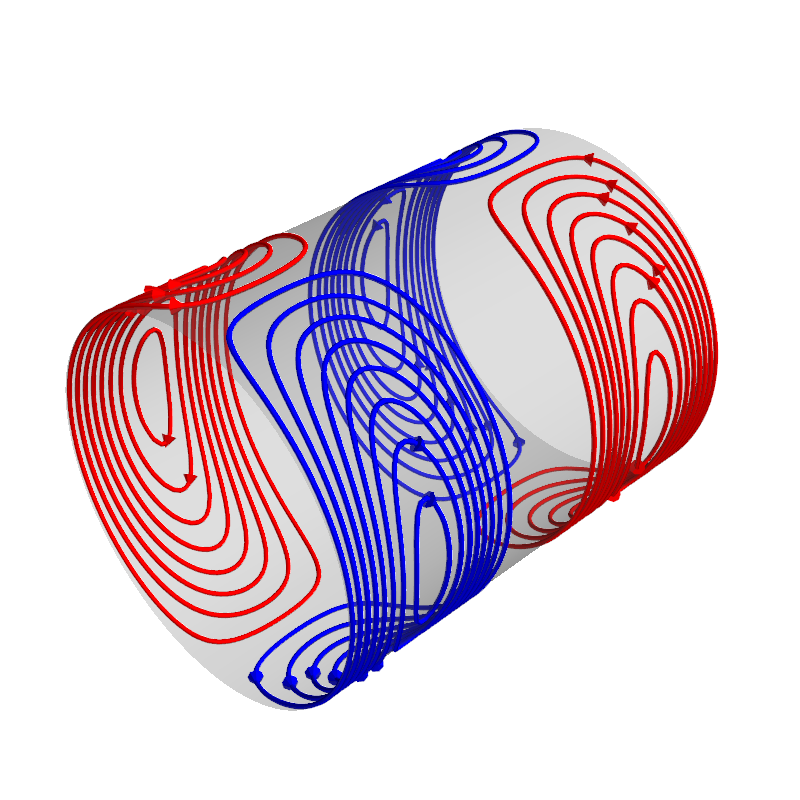

In [23]:
f = coil.plot_mesh(opacity=0.3)
loops = coil.s.discretize(N_contours=16)
loops.plot_loops(figure=f)

In [65]:
phi = np.linspace(-np.pi, np.pi, 200)
z = np.linspace(-65, 65, 200)
phi2D, z2D = np.meshgrid(phi, z)
R = 50

In [66]:
s_func = coil.s.vert
mesh_vert = coil.mesh.vertices
vert_rad = []
for v in mesh_vert: # X axis cilynder
    x, y, z = v
    theta = np.arctan2(y, z)
    vert_rad.append([theta, x])
vert_rad = np.array(vert_rad)
s_func.shape, vert_rad.shape

np.savetxt("stream_func50mm_phi_z.txt", np.column_stack((vert_rad, s_func)))

In [79]:
s_func_int = griddata(vert_rad, s_func, (phi2D, z2D), method="cubic", fill_value=0)

In [80]:
s_func_int

array([[ 0.00000000e+00,  0.00000000e+00, -8.85128326e-07, ...,
        -1.96252667e-06,  8.49454641e-07,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -9.68029545e-01, ...,
         8.86674725e-01,  4.65045741e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.85002494e+00, ...,
         1.71943063e+00,  8.67972804e-01,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  1.72462532e+00, ...,
        -1.79957280e+00, -9.47961376e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  9.24754284e-01, ...,
        -9.09764677e-01, -4.81741187e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.21494733e-07, ...,
         2.12448826e-06, -9.29019505e-07,  0.00000000e+00]])

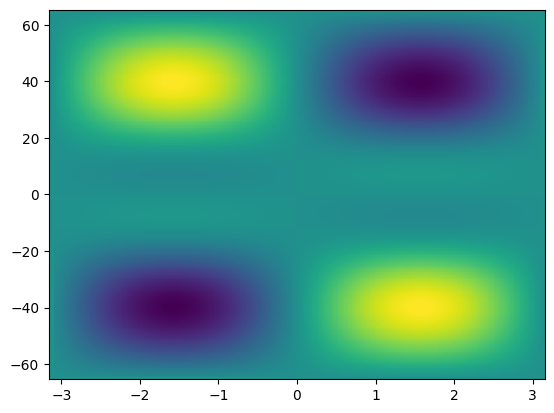

In [81]:
plt.pcolormesh(phi2D, z2D, s_func_int)

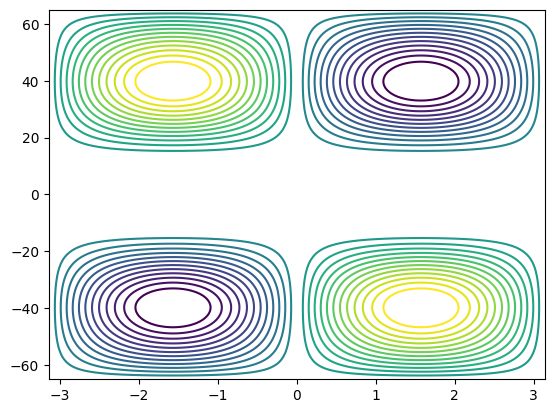

In [113]:
numWires = 12
levels = np.linspace(np.amin(s_func_int), np.amax(s_func_int), numWires*2 + 4)
levels = levels[1:-1]
# Wire should be laid along contours between the isolines, calculate midpoint between isolines
midPointLevels = [(levels[i]+levels[i+1])/2 for i in range(np.size(levels)-1)]
midPointLevels = np.array(midPointLevels)[np.abs(midPointLevels) >= 1e-1] #remove zeros, account for floating point error
midPointLevels
# plt.ioff()
# plt.figure()
contours = plt.contour(phi2D,z2D,s_func_int,levels = midPointLevels)

In [116]:
wireNum = 0
contourDict = {}
conjoined = True
wireLevels = contours.allsegs
direction = 0

if ((direction == 0) and conjoined):        #for the X gradient the center of the smallest contour is needed for joining the wires
    minLength = np.inf
    for wireLevel in wireLevels:
        for wire in wireLevel:
            if(np.size(wire,0) < minLength):
                centerHeight = np.abs(np.mean(wire[:,1]))

for wireLevel in wireLevels:
    for wire in wireLevel:
        wirePath3D = np.stack((np.cos(wire[:,0])*R,np.sin(wire[:,0])*R,wire[:,1]),axis=1)
        if(conjoined):
            gapSize = 4 #gap in which the sections are joined
            gapAngle = gapSize/R      
            centerAngle = np.mean(wire[:,0])
            
            if(direction == 0):
                mask = (np.abs(wire[:,0] - centerAngle) > gapAngle) | (np.abs(wirePath3D[:,2]) < centerHeight)
            else:
                mask = (np.abs(wire[:,0] - centerAngle) > gapAngle) | (wirePath3D[:,2] < 0)
            
            while mask[0]:
                mask = np.roll(mask,1)
                wirePath3D = np.roll(wirePath3D, 1, axis = 0)
    
            contourDict[str(wireNum)] = np.stack((wirePath3D[mask, 0],wirePath3D[mask, 1],wirePath3D[mask, 2]),axis=1)
        else:
            contourDict[str(wireNum)] = wirePath3D
        wireNum += 1

if(not conjoined):
    pass
else:
    
    #############################################
    # Join the wires with a gap in to one array #
    #############################################
    
    numCoilSegments = 4             #Number of quadrants

    joinedContour = {}
    joinedContour[str(0)] = contourDict[str(0)]
    joinedContour[str(1)] = contourDict[str(1)]
    joinedContour[str(2)] = contourDict[str(int(2*wireNum/numCoilSegments))]
    joinedContour[str(3)] = contourDict[str(int(2*wireNum/numCoilSegments)+1)]
    
    for idx in range(1,int(wireNum/numCoilSegments)):
        joinedContour[str(0)] = np.append(joinedContour[str(0)], contourDict[str(2*idx)], axis = 0)
        joinedContour[str(1)] = np.append(joinedContour[str(1)], contourDict[str(2*idx+1)], axis = 0)
        joinedContour[str(2)] = np.append(joinedContour[str(2)], contourDict[str(int(2*wireNum/numCoilSegments) + idx*2 )], axis = 0)
        joinedContour[str(3)] = np.append(joinedContour[str(3)], contourDict[str(int(2*wireNum/numCoilSegments) + idx*2 +1)], axis = 0)
    
    
    ############################################
    # Check for consecutive identical elements #
    ############################################
    tol = 1e-5
    for key in joinedContour:
        delta = joinedContour[key][1:,:] - joinedContour[key][:-1,:]
        delta = np.sum(np.square(delta), axis = 1)
        zeroElements = delta < tol
        joinedContour[key] = np.delete(joinedContour[key],np.nonzero(zeroElements), axis = 0)


In [120]:
mlab.init_notebook('png')

Notebook initialized with png backend.



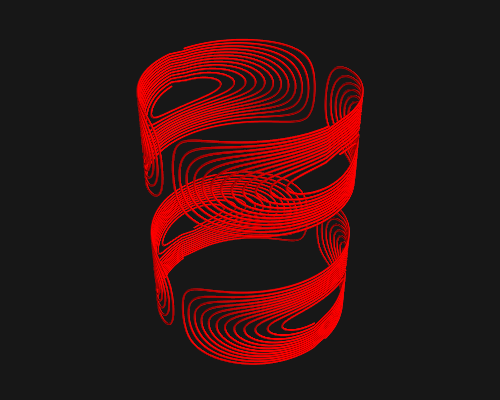

In [121]:
f = mlab.figure(bgcolor=(23./255, 23./255, 23./255), fgcolor=(.5, .5, .5), size=(500, 400))
for i in range(4):
    mlab.plot3d(*joinedContour[str(i)].T, color=(1, 0, 0), tube_radius=0.5)
f

In [11]:
loops_dict = loops.to_dict()


paths = loops_dict['entities']
verts = loops_dict['vertices']

vertices = []

radius = 42
vertices_proj = []

for v in verts: # X axis cilynder
    x, y, z = v
    vertices.append((x, y, z))
    theta = np.arctan2(y, z)
    l = theta*radius
    vertices_proj.append((l, x, 0))

path = []
for p in paths:
    line = p['points']
    for i in range(len(line)):
        if i == len(line)-1:
            path.append((line[i], line[0]))
        else:
            path.append((line[i], line[i+1]))

In [12]:
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.interpolate import splprep, splev


col = plt.cm.viridis(np.linspace(0, 1, int(len(paths)/4)))

def spline_length(spl, closed=False):
    u = np.linspace(0, 1, 100)
    I = 0
    add_cl = 0 if closed else 0
    for i in range(len(u)-add_cl):
        if closed and i == len(u)-1:
            I += np.linalg.norm(np.array(splev(u[i], spl)) - np.array(splev(u[0], spl)))
        else:
            I += np.linalg.norm(np.array(splev(u[i+1], spl)) - np.array(splev(u[i], spl)))
    
    return I

L = []
L_proj = []
for j in range(len(paths)):
    line = np.array([list(vertices[i]) for i in paths[j]['points']])
    # plt.plot(*line.T, alpha=0.3, color='k')
    L.append(line)
    line = np.array([list(vertices_proj[i]) for i in paths[j]['points']])
    # plt.plot(*line.T, alpha=0.3, color='k')
    L_proj.append(line)

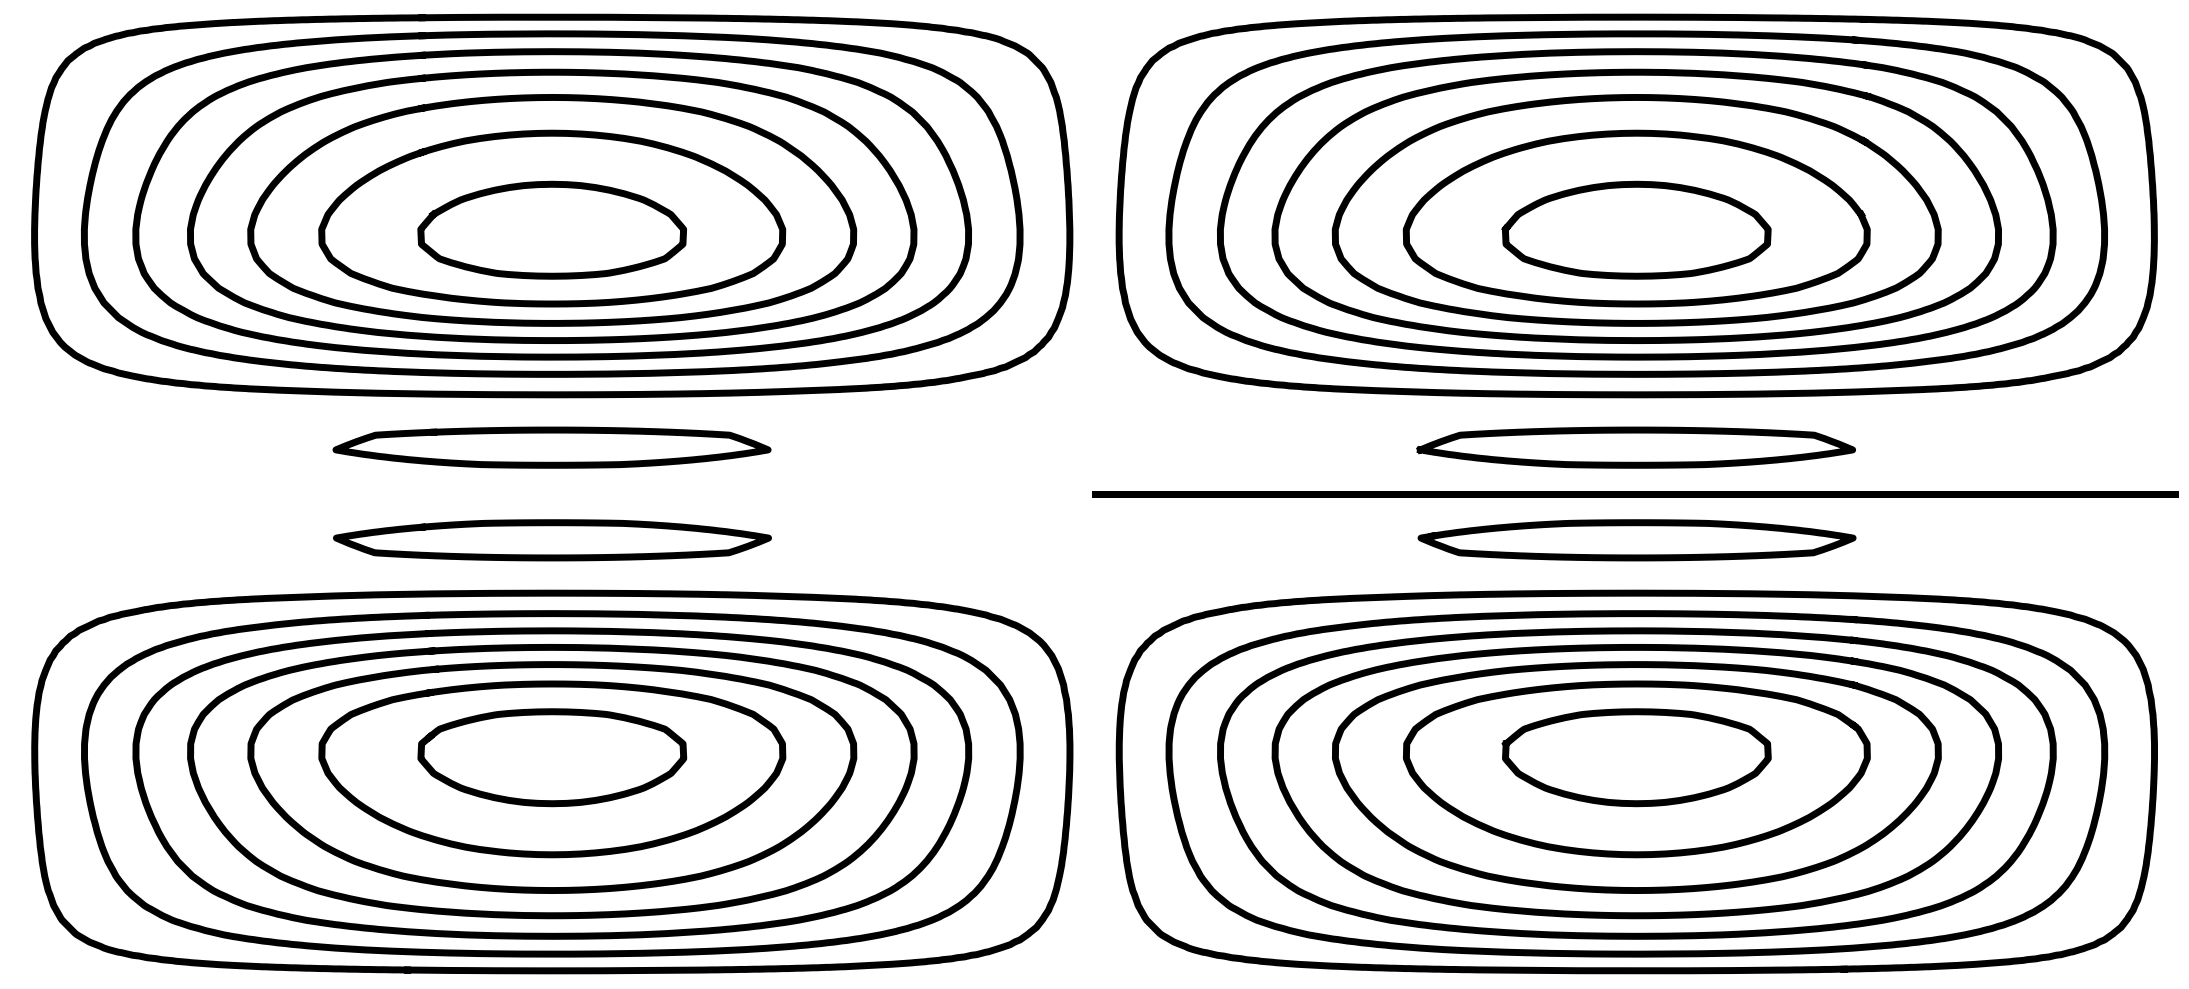

In [13]:
ratio = radius*np.pi/60

fig = plt.figure(figsize=(10*ratio, 10), dpi=100)
for i in L_proj:
    p = np.array(i)
    plt.plot(*p.T, color="k", linewidth=5)
plt.xlim(-radius*np.pi, radius*np.pi)
plt.ylim(-60, 60)
plt.subplots_adjust(left=0.0, right=1, top=1, bottom=0)
plt.axis('off')
fig.tight_layout()
fig.savefig('Cyl_42mm_HR_grad_x.png', bbox_inches='tight', dpi=100)



## Refactor contours with equally spaced points

In [14]:
new_vertices = []
new_edges = []
tot_len = 0
index = 0

res = 0.9
closed = True

for line in L: #tl+tr+br+bl
    spl, _ = splprep(line.T, s=0)
    l = spline_length(spl, True)
    tot_len+=l
    points = np.linspace(0, 1, int(l/res))

    for i, p in enumerate(points):
        
        vert = tuple(list(np.array(splev(p, spl))))
        new_vertices.append(vert)
        
        if i > 0:
            new_edges.append((index-1, index))
        index+=1

# print(line)
print(new_edges[-1])
print(tot_len)


(6675, 6676)
6025.081553953578


# For blender

In [14]:
# new_vertices = np.array(new_vertices)
# new_edges = np.array(new_edges, dtype=np.int32)

# with open('vertices_closed_3.txt', 'w') as f:
#    np.savetxt(f, new_vertices)

# with open('edges_closed_3.txt', 'w') as f:
#    np.savetxt(f, new_edges)

### Path by path export

In [15]:
tot_len = 0
index = 0

res = 1
closed = True
for j, line in enumerate(L): #tl+tr+br+bl
    verts = []
    spl, _ = splprep(line.T, s=0)
    l = spline_length(spl, True)
    tot_len+=l
    points = np.linspace(0, 1, int(l/res))

    for i, p in enumerate(points):
        
        vert = tuple(list(np.array(splev(p, spl))))
        verts.append(vert)
        
    np.savetxt(f"line_path/{j}.txt", verts)
    